![](img/572_banner.png)
%%HTML
<script src="require.js"></script>

# Appendix B: Logistic Loss

## Imports
<hr>

In [ ]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/neural-networks'):
    !git clone -q https://github.com/fum-cs/neural-networks.git /content/neural-networks
    !pip --quiet install -r /content/neural-networks/requirements_colab.txt
    %cd neural-networks/notebooks

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

## 1. Logistic Regression Refresher
<hr>

Logistic Regression is a classification model where we calculate the probability of an observation belonging to a class as:

$$z=w^Tx$$

$$\hat{y} = \frac{1}{(1+\exp(-z))}$$

And then assign that observation to a class based on some threshold (usually 0.5):

$$\text{Class }\hat{y}=\left\{
\begin{array}{ll}
    0, & \hat{y}\le0.5 \\
    1, & \hat{y}>0.5 \\
\end{array} 
\right.$$

## 2. Motivating the Loss Function
<hr>

- In [Lecture 2](lecture2_gradient-descent.ipynb) we focussed on the mean squared error as a loss function for optimizing linear regression:

$$f(w)=\frac{1}{n}\sum^{n}_{i=1}(\hat{y}-y_i))^2$$

- That won't work for logistic regression classification problems because it ends up being "non-convex" (which basically means there are multiple minima)
- Instead we use the following loss function:

$$f(w)=-\frac{1}{n}\sum_{i=1}^ny_i\log\left(\frac{1}{1 + \exp(-w^Tx_i)}\right) + (1 - y_i)\log\left(1 - \frac{1}{1 + \exp(-w^Tx_i)}\right)$$

- This function is called the "log loss" or "binary cross entropy"
- I want to visually show you the differences in these two functions, and then we'll discuss why that loss functions works
- Recall the Pokemon dataset from [Lecture 2](lecture2_gradient-descent.ipynb), I'm going to load that in again (and standardize the data while I'm at it):

In [2]:
df = pd.read_csv("data/pokemon.csv", usecols=['name', 'defense', 'attack', 'speed', 'capture_rt', 'legendary'])
x = StandardScaler().fit_transform(df.drop(columns=["name", "legendary"]))
X = np.hstack((np.ones((len(x), 1)), x))
y = df['legendary'].to_numpy()
df.head()

name  attack  defense  speed  capture_rt  legendary
0   Bulbasaur      49       49     45          45          0
1     Ivysaur      62       63     60          45          0
2    Venusaur     100      123     80          45          0
3  Charmander      52       43     65          45          0
4  Charmeleon      64       58     80          45          0

- The goal here is to use the features (but not "name", that's just there for illustration purposes) to predict the target "legendary" (which takes values of 0/No and 1/Yes).
- So we have 4 features meaning that our logistic regression model will have 5 parameters that need to be estimated (4 feature coefficients and 1 intercept)
- At this point let's define our loss functions:

In [3]:
def sigmoid(w, x):
    """Sigmoid function (i.e., logistic regression predictions)."""
    return 1 / (1 + np.exp(-x @ w))


def mse(w, x, y):
    """Mean squared error."""
    return np.mean((sigmoid(w, x) - y) ** 2)


def logistic_loss(w, x, y):
    """Logistic loss."""
    return -np.mean(y * np.log(sigmoid(w, x)) + (1 - y) * np.log(1 - sigmoid(w, x)))

- For a moment, let's assume a value for all the parameters execpt for $w_1$
- We will then calculate the mean squared error for different values of $w_1$ as in the code below

In [4]:
w1_arr = np.arange(-3, 6.1, 0.1)
losses = pd.DataFrame({"w1": w1_arr,
                       "mse": [mse([0.5, w1, -0.5, 0.5, -2], X, y) for w1 in w1_arr],
                       "log": [logistic_loss([0.5, w1, -0.5, 0.5, -2], X, y) for w1 in w1_arr]})
losses.head()

w1       mse       log
0 -3.0  0.451184  1.604272
1 -2.9  0.446996  1.571701
2 -2.8  0.442773  1.539928
3 -2.7  0.438537  1.508997
4 -2.6  0.434309  1.478955

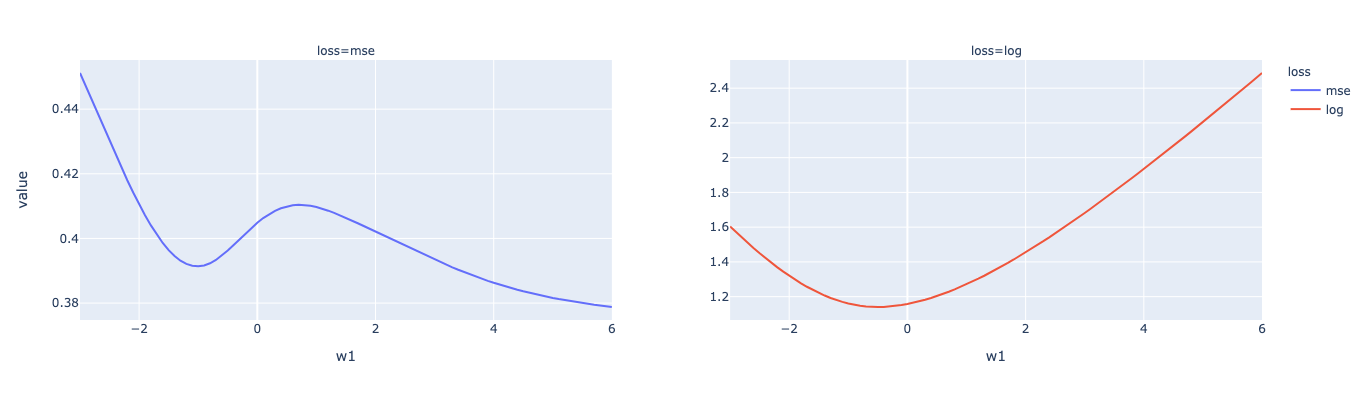

In [5]:
fig = px.line(losses.melt(id_vars="w1", var_name="loss"), x="w1", y="value", color="loss", facet_col="loss", facet_col_spacing=0.1)
fig.update_yaxes(matches=None, showticklabels=True, col=2)
fig.update_xaxes(matches=None, showticklabels=True, col=2)
fig.update_layout(width=800, height=400)

- This is a pretty simple dataset but you can already see the "non-convexity" of the MSE loss function.
- If you want a more mathematical description of the logistic loss function, check out [Chapter 3 of Neural Networks and Deep Learning by Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html) or [this Youtube video by Andrew Ng](https://www.youtube.com/watch?v=HIQlmHxI6-0).

## 3. Breaking Down the Log Loss Function
<hr>

- So we saw the log loss before:

$$f(w)=-\frac{1}{n}\sum_{i=1}^ny_i\log\left(\frac{1}{1 + \exp(-w^Tx_i)}\right) + (1 - y_i)\log\left(1 - \frac{1}{1 + \exp(-w^Tx_i)}\right)$$

- It looks complicated but it's actually quite simple. Let's break it down.
- Recall that we have a binary classification task here so $y_i$ can only be 0 or 1.

### When `y = 1`

- When $y_i = 1$ we are left with:

$$f(w)=-\frac{1}{n}\sum_{i=1}^n\log\left(\frac{1}{1 + \exp(-w^Tx_i)}\right)$$

- That looks fine!
- With $y_i = 1$, if $\hat{y_i} = \frac{1}{1 + \exp(-w^Tx_i)}$ is also close to 1 we want the loss to be small, if it is close to 0 we want the loss to be large, that's where the `log()` comes in:

In [6]:
y = 1
y_hat_small = 0.05
y_hat_large = 0.95

In [7]:
-np.log(y_hat_small)

2.995732273553991

In [8]:
-np.log(y_hat_large)

0.05129329438755058

### When `y = 0`

- When $y_i = 1$ we are left with:

$$f(w)=-\frac{1}{n}\sum_{i=1}^n\log\left(1 - \frac{1}{1 + \exp(-w^Tx_i)}\right)$$

- With $y_i = 0$, if $\hat{y_i} = \frac{1}{1 + \exp(-w^Tx_i)}$ is also close to 0 we want the loss to be small, if it is close to 1 we want the loss to be large, that's where the `log()` comes in:

In [9]:
y = 0
y_hat_small = 0.05
y_hat_large = 0.95

In [10]:
-np.log(1 - y_hat_small)

0.05129329438755058

In [11]:
-np.log(1 - y_hat_large)

2.99573227355399

### Plot Log Loss

- We know that our predictions from logistic regression $\hat{y}$ are limited between 0 and 1 thanks to the sigmoid function
- So let's plot the losses because it's interesting to see how the worse our predictions are, the worse the loss is (i.e., if $y=1$ and our model predicts $\hat{y}=0.05$, the penalty is exponentially bigger than if the prediction was $\hat{y}=0.90$)

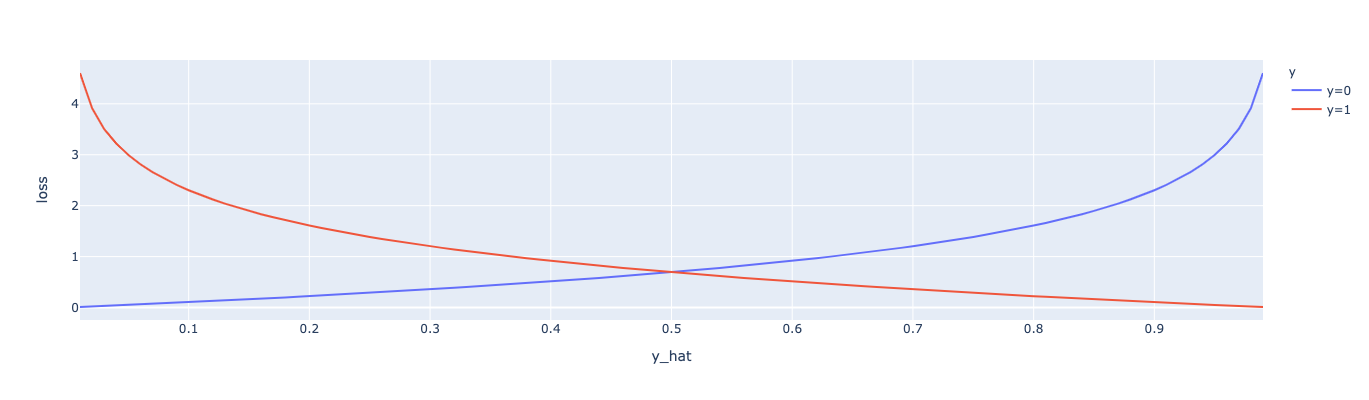

In [12]:
y_hat = np.arange(0.01, 1.00, 0.01)
log_loss = pd.DataFrame({"y_hat": y_hat,
                         "y=0": -np.log(1 - y_hat),
                         "y=1": -np.log(y_hat)}).melt(id_vars="y_hat", var_name="y", value_name="loss")
fig = px.line(log_loss, x="y_hat", y="loss", color="y")
fig.update_layout(width=500, height=400)

## 4. Log Loss Gradient
<hr>

- In [Lecture 2](lecture2_gradient-descent.ipynb) we used the gradient of the log loss to implement gradient descent
- Here's the log loss and it's gradient:

$$f(w)=-\frac{1}{n}\sum_{i=1}^ny_i\log\left(\frac{1}{1 + \exp(-w^Tx_i)}\right) + (1 - y_i)\log\left(1 - \frac{1}{1 + \exp(-w^Tx_i)}\right)$$

$$\frac{\partial f(w)}{\partial w}=\frac{1}{n}\sum_{i=1}^nx_i\left(\frac{1}{1 + \exp(-w^Tx_i)} - y_i)\right)$$

- Let's derive that now.
- We'll denote:

$$z = -w^Tx_i$$

$$\sigma(z) = \frac{1}{1 + \exp(z)}$$

- Such that:

$$f(w)=-\frac{1}{n}\sum_{i=1}^ny_i\log\sigma(z) + (1 - y_i)\log(1 - \sigma(z))$$

- Okay let's do it:

$$
\begin{equation}
\begin{split}
\frac{\partial f(w)}{\partial w} & =-\frac{1}{n}\sum_{i=1}^ny_i \times \frac{1}{\sigma(z)} \times \frac{\partial \sigma(z)}{\partial w} + (1 - y_i) \times \frac{1}{1 - \sigma(z)} \times -\frac{\partial \sigma(z)}{\partial w} \\
& =-\frac{1}{n}\sum_{i=1}^n\left(\frac{y_i}{\sigma(z)} - \frac{1 - y_i}{1 - \sigma(z)}\right)\frac{\partial \sigma(z)}{\partial w} \\
& =\frac{1}{n}\sum_{i=1}^n \frac{\sigma(z)-y_i}{\sigma(z)(1 - \sigma(z))}\frac{\partial \sigma(z)}{\partial w}
\end{split}
\end{equation}
$$

- Now we just need to work out $\frac{\partial \sigma(z)}{\partial w}$, I'll mostly skip this part but there's an intuitive derivation [here](https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d), it's just about using the chain rule:

$$
\begin{equation}
\begin{split}
\frac{\partial \sigma(z)}{\partial w} & = \frac{\partial \sigma(z)}{\partial z} \times \frac{\partial z}{\partial w}\\
& = \sigma(z)(1-\sigma(z))x_i \\
\end{split}
\end{equation}
$$

- So finally:

$$
\begin{equation}
\begin{split}
\frac{\partial f(w)}{\partial w} & =\frac{1}{n}\sum_{i=1}^n \frac{\sigma(z)-y_i}{\sigma(z)(1 - \sigma(z))} \times \sigma(z)(1-\sigma(z))x_i \\
& = \frac{1}{n}\sum_{i=1}^nx_i(\sigma(z)-y_i) \\
& = \frac{1}{n}\sum_{i=1}^nx_i\left(\frac{1}{1 + \exp(-w^Tx_i)} - y_i)\right)
\end{split}
\end{equation}
$$